# 자전거대여 예측
## colab에서 실행

## 데이터 https://goo.gl/s8qSL5

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/swkim01/DSAC3/blob/main/gg-38-자전거대여예측.ipynb"><img src="https://github.com/swkim01/DSAC3/raw/main/colab_logo_32px.png" />구글 코랩에서 실행</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/swkim01/DSAC3/blob/main/gg-38-자전거대여예측.ipynb"><img src="https://github.com/swkim01/DSAC3/raw/main/GitHub-Mark-32px.png" />깃헙에서 소스 보기</a>
  </td>
</table>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
%matplotlib inline

## colab에서 실행하는 경우 필요한 코드

In [2]:
#!curl -L https://goo.gl/s8qSL5  -o ./bike_train.csv
!curl -L https://github.com/swkim01/DSAC3/raw/main/bike_train.csv  -o ./bike_train.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133    0   133    0     0    841      0 --:--:-- --:--:-- --:--:--   841
100  643k  100  643k    0     0  1721k      0 --:--:-- --:--:-- --:--:-- 1721k


In [3]:
train = pd.read_csv("bike_train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 데이터 분해

In [5]:
train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day", "d-hour", "d-minute", "d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


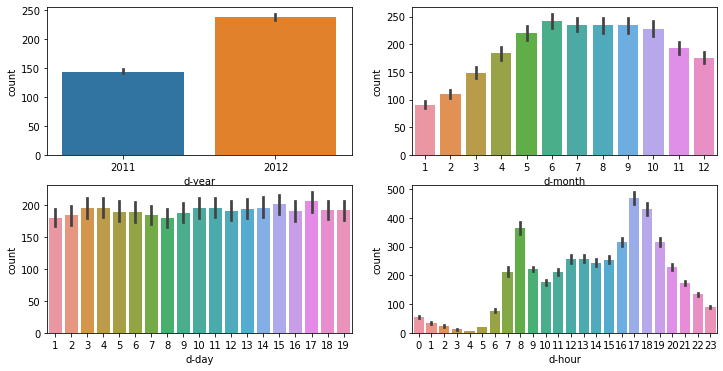

In [6]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 6)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)
sns.barplot(data=train, x="d-day", y="count", ax=ax3)
sns.barplot(data=train, x="d-hour", y="count", ax=ax4)

## 시간대별 평균 대여수 (주중, 주말 구분)

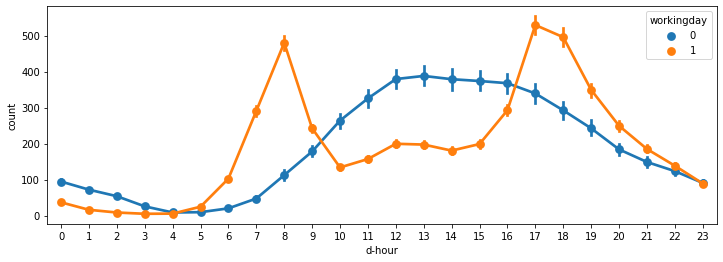

In [7]:
plt.figure(figsize=(12,4))
sns.pointplot(data=train, x="d-hour", y="count", hue="workingday")

## 시간대별 대여수 - 요일 구분

In [8]:
train["d-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


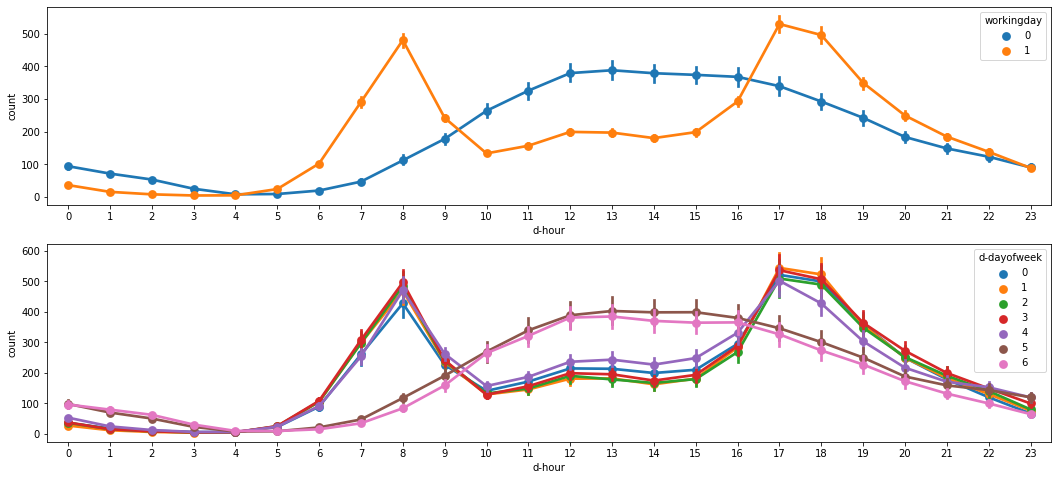

In [9]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

sns.pointplot(data=train, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=train, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 연도와 월을 합한 특성 변수 생성

In [10]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["d-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "d-year_month"]].head()

(10886, 20)


,datetime,d-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


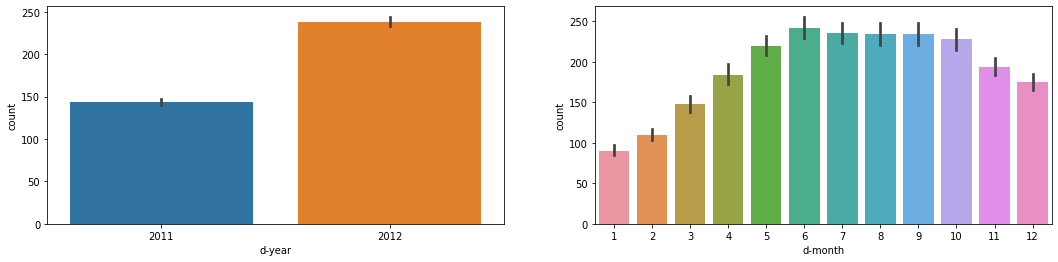

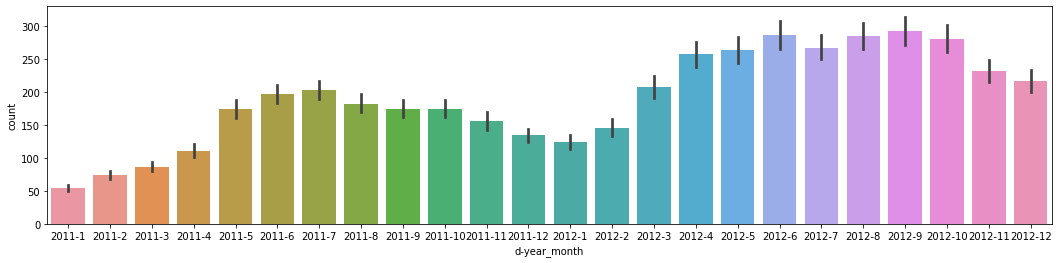

In [11]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year_month", y="count", ax=ax3)

## 훈련에 사용할 특성 선택

In [12]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-minute', 'd-second',
       'd-dayofweek', 'd-year_month'],
      dtype='object')

In [13]:
features = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "d-year", "d-hour", "d-dayofweek"]

In [14]:
X = train[features]
print(X.shape)
X.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [15]:
y = train["count"]
print(y.shape)

(10886,)


In [16]:
import numpy as np
y_log = np.log(y + 1)

print(y_log.shape)
y_log.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

## 간단한 예측 모델

In [17]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.2)

In [18]:
model = RandomForestRegressor(n_estimators= 30)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9580883210969734

In [19]:
list(zip(y_test, model.predict(X_test)))[:10]

[(1.9459101490553132, 2.0403146519508772),
 (3.7612001156935624, 3.7669927593559467),
 (6.415096959171596, 6.302535786676932),
 (2.833213344056216, 2.824032746730312),
 (4.2626798770413155, 4.443539522423507),
 (2.70805020110221, 3.2117684044501233),
 (6.030685260261263, 5.914215047904423),
 (5.4510384535657, 5.41472429655433),
 (5.472270673671475, 5.697741213725065),
 (5.673323267171493, 5.595541299114385)]

In [20]:
X_train[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
7560,2,0,1,3,22.14,25.760,88,19.0012,2012,9,0
8090,2,0,0,1,25.42,31.060,57,7.0015,2012,11,6
30,1,0,0,2,16.40,20.455,76,12.9980,2011,7,6
7290,2,0,1,2,18.86,22.725,88,0.0000,2012,3,3
8665,3,0,1,2,32.80,37.120,52,12.9980,2012,10,4


## 선형회귀

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.47259501985060987

In [22]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.915749021768606

### 전문가 지식 활용

In [23]:
X1 = train[1323:1770] # 20110306 - 20110510 , 455
X1.head()
y1 = X1["count"]
#y1.head()

DatetimeIndex(['2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04',
               '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-08',
               '2011-04-09', '2011-04-10', '2011-04-11', '2011-04-12',
               '2011-04-13', '2011-04-14', '2011-04-15', '2011-04-16',
               '2011-04-17', '2011-04-18', '2011-04-19'],
              dtype='datetime64[ns]', freq='D')


Text(0, 0.5, 'count')

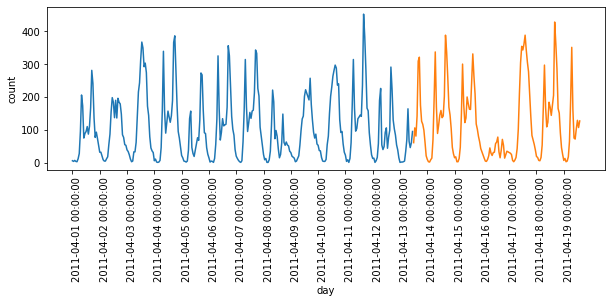

In [24]:
X2 = X1["datetime"].values.reshape(-1, 1)
Xtrain, Xtest = X2[:300], X2[300:]
ytrain, ytest = y1[:300], y1[300:]
plt.figure(figsize=(10,3))
xticks_name = pd.date_range(start=X2.min(), end=X2.max(), freq='D')
print(xticks_name)
plt.xticks(range(0, len(X2), 24), xticks_name, rotation=90, ha="left")
plt.plot(range(300), ytrain, label="train")
plt.plot(range(300, len(ytest) + 300), ytest, '-', label="test")
plt.xlabel("day")
plt.ylabel("count")

In [25]:
n_train = 300
def plot_result(features, target, regressor):
  Xtrain, Xtest = features[:n_train], features[n_train:]
  ytrain, ytest = target[:n_train], target[n_train:]
  regressor.fit(Xtrain, ytrain)
  print("R^2: {:,.2f}".format(regressor.score(Xtest, ytest)))
  ypred = regressor.predict(Xtest)
  ypred_train = regressor.predict(Xtrain)
  plt.figure(figsize=(10,3))
  plt.xticks(range(0, len(features), 24), xticks_name, rotation=90, ha="left")
  plt.plot(range(n_train), ytrain, label="train")
  plt.plot(range(n_train, len(ytest) + n_train), ytest, '-', label="test")
  plt.plot(range(n_train), ypred_train, '--', label="train predict")
  plt.plot(range(n_train, len(ytest) + n_train), ypred, '-', label="test predict")
  plt.xlabel("day")
  plt.ylabel("count")

R^2: -0.05


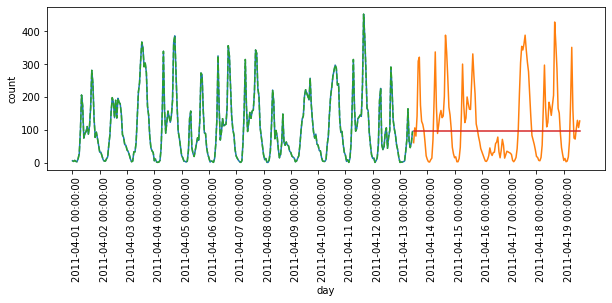

In [26]:
model = DecisionTreeRegressor()
plot_result(X1["datetime"].values.reshape(-1, 1), y1, model)

R^2: 0.55


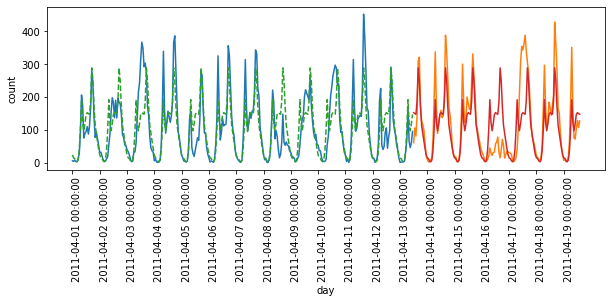

In [27]:
model = DecisionTreeRegressor()
plot_result(X1["d-hour"].values.reshape(-1, 1), y1, model)

## 성능 지표( score) 함수 변경

In [28]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = predict + 1
    log_actual = actual + 1
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()    
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## 하이퍼파라미터 선택

### 그리드 탐색

In [29]:
n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = []

for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=5,
                                scoring=rmsle_scorer).mean()

        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

Score = 0.49337
Score = 0.40474
Score = 0.35616
Score = 0.40958
Score = 0.34844
Score = 0.32684
Score = 0.41321
Score = 0.34933
Score = 0.32768


[{'max_depth': 10,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.4933716623103215},
 {'max_depth': 10,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.4047436481972948},
 {'max_depth': 10,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.35616225270175655},
 {'max_depth': 20,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.40957527563664387},
 {'max_depth': 20,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.3484355049754384},
 {'max_depth': 20,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.3268438131004311},
 {'max_depth': 30,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.4132067623268488},
 {'max_depth': 30,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.3493330277052885},
 {'max_depth': 30,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.32768237093321617}]

In [30]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

(9, 4)


,score,n_estimators,max_depth,max_features
5,0.326844,30,20,0.9
8,0.327682,30,30,0.9
4,0.348436,30,20,0.5
7,0.349333,30,30,0.5
2,0.356162,30,10,0.9


### 랜덤 탐색

In [31]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

hyperparameters_list = []

n_estimators = 30
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=2, high=100)
    max_features = np.random.uniform(low=0.1, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.32593
Score = 0.33057
Score = 0.56139
Score = 0.56134
Score = 0.35105
Score = 0.75337
Score = 0.33773
Score = 0.34663
Score = 0.33773
Score = 0.33057
(10, 4)


,score,n_estimators,max_depth,max_features
0,0.325933,30,27,0.742105
1,0.330568,30,53,0.724711
9,0.330568,30,82,0.708922
6,0.337729,30,79,0.575713
8,0.337729,30,74,0.577014


### 상세 탐색

In [32]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

hyperparameters_list = []

n_estimators = 10
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=10, high=70)
    max_features = np.random.uniform(low=0.4, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.35628
Score = 0.34129
Score = 0.35628
Score = 0.33966
Score = 0.35506
Score = 0.33966
Score = 0.34129
Score = 0.33882
Score = 0.36444
Score = 0.35506
(10, 4)


,score,n_estimators,max_depth,max_features
7,0.338818,10,67,0.916531
3,0.339665,10,65,0.841677
5,0.339665,10,49,0.873149
1,0.341294,10,34,0.807500
6,0.341294,10,48,0.802131


## 최종 모델 선택

In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300,
                              max_depth=83,
                              max_features=0.851358,
                              random_state=37,
                              n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=83, max_features=0.851358, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=37, verbose=0, warm_start=False)

## Score (rmsle)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [34]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, X_train, y_train, cv=5,
                        scoring=rmsle_scorer).mean()

print("Score = {0:.5f}".format(score))

Score = 0.31860


## 주요 특성 변수

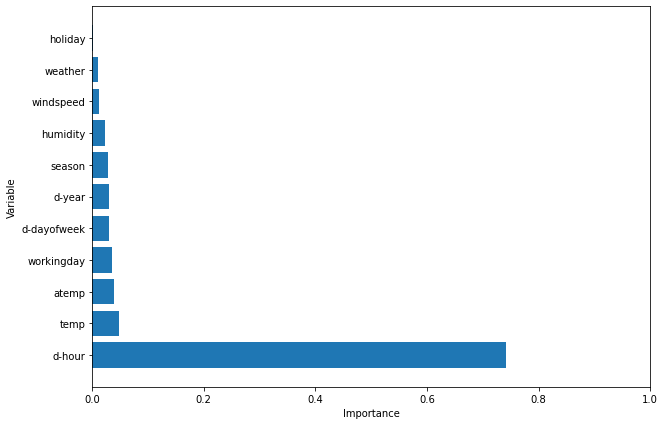

In [35]:
df = pd.DataFrame({'feature':features,'importance':model.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()